# GDA

<>:153: SyntaxWarning: invalid escape sequence '\l'
<>:155: SyntaxWarning: invalid escape sequence '\l'
<>:156: SyntaxWarning: invalid escape sequence '\l'
<>:153: SyntaxWarning: invalid escape sequence '\l'
<>:155: SyntaxWarning: invalid escape sequence '\l'
<>:156: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_2208/2495068500.py:153: SyntaxWarning: invalid escape sequence '\l'
  axs[1, 0].plot(range(n_iters + 1), lambdas, 'm-', label='$\lambda_k$')
/tmp/ipykernel_2208/2495068500.py:155: SyntaxWarning: invalid escape sequence '\l'
  axs[1, 0].set_ylabel('Giá trị $\lambda_k$')
/tmp/ipykernel_2208/2495068500.py:156: SyntaxWarning: invalid escape sequence '\l'
  axs[1, 0].set_title('Kích thước bước $\lambda_k$')


Chạy thuật toán GDA từ nhiều điểm bắt đầu khác nhau:
Điểm bắt đầu 1: [3.06944712 1.54675959]
  + Số lần lặp: 100
  + Điểm cuối: [0.8916019  1.79735267]
  + Giá trị hàm mục tiêu: 0.4093590646404781
  + Kiểm tra ràng buộc: True

Điểm bắt đầu 2: [2.18382498 3.80466644]
  + Số lần lặp: 100
  + Điểm cuối: [0.89159602 1.79737041]
  + Giá trị hàm mục tiêu: 0.4093590646928338
  + Kiểm tra ràng buộc: True

Điểm bắt đầu 3: [2.35430499 3.88789515]
  + Số lần lặp: 100
  + Điểm cuối: [0.89159483 1.79737399]
  + Giá trị hàm mục tiêu: 0.40935906470880173
  + Kiểm tra ràng buộc: True

Điểm tốt nhất tìm được: [0.8916019  1.79735267]
Giá trị hàm mục tiêu tại điểm tốt nhất: 0.4093590646404781

Vẽ đồ thị quá trình hội tụ cho điểm bắt đầu tốt nhất (điểm 1):


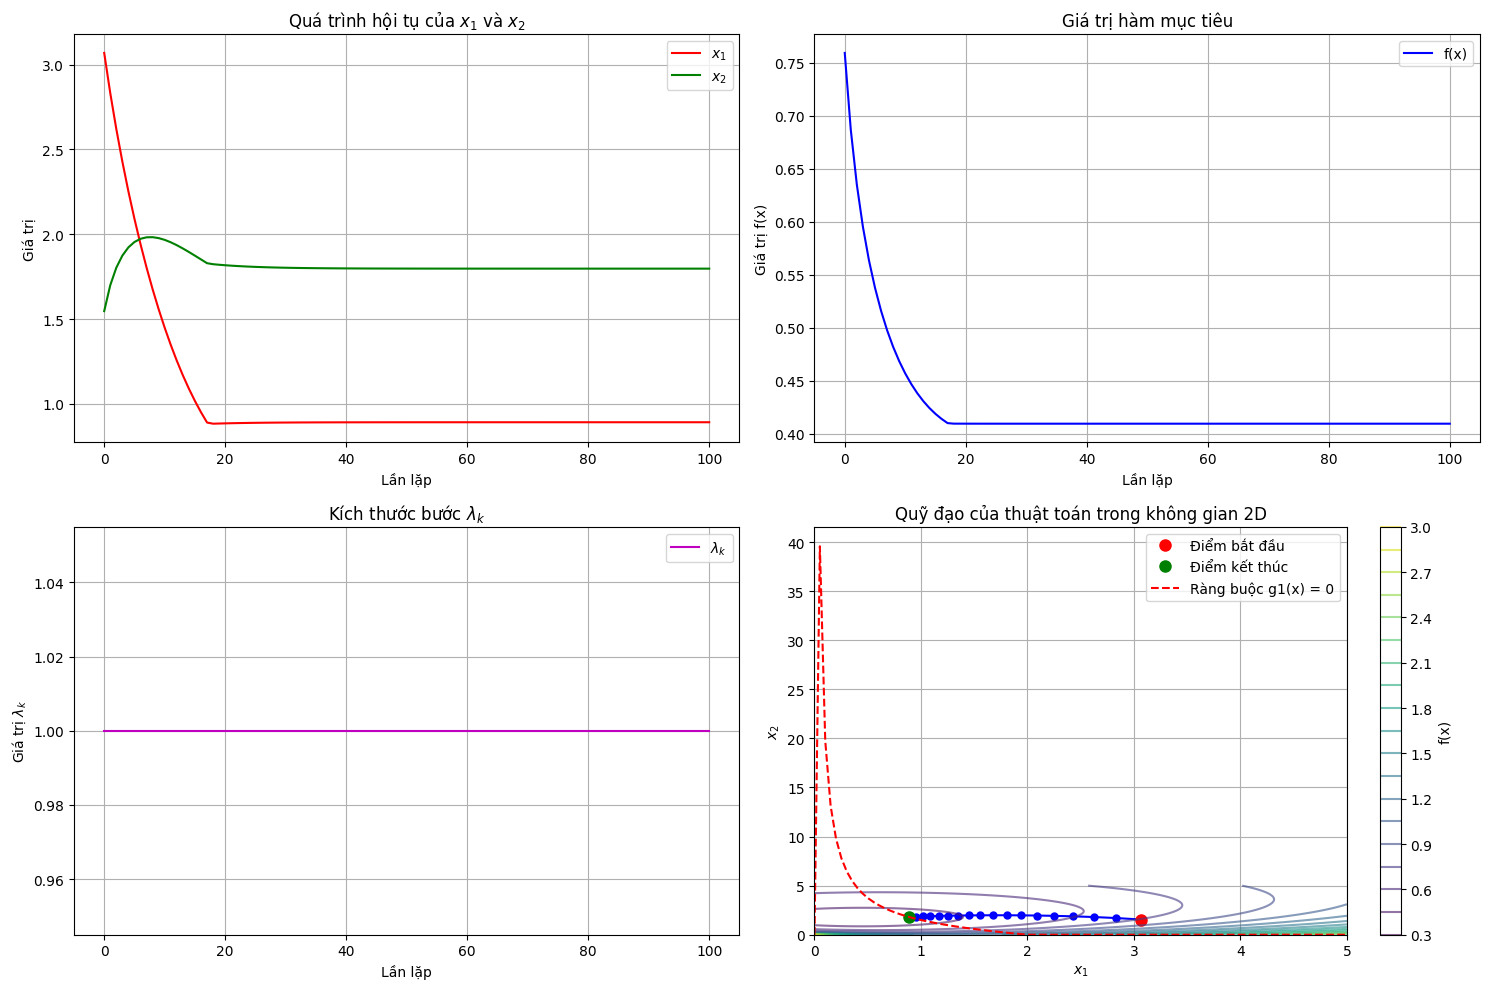

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import Bounds
import time

def f(x):
    # """
    # Hàm mục tiêu: f(x) = (x_1^2 + x_2^2 + 3) / (1 + 2*x_1 + 8*x_2)
    # """
    return (x[0]**2 + x[1]**2 + 3) / (1 + 2*x[0] + 8*x[1])

def f_grad(x):
    # """
    # Gradient của hàm mục tiêu f(x)
    # """
    numerator = x[0]**2 + x[1]**2 + 3
    denominator = 1 + 2*x[0] + 8*x[1]
    
    df_dx1 = (2*x[0]*denominator - 2*numerator) / (denominator**2)
    df_dx2 = (2*x[1]*denominator - 8*numerator) / (denominator**2)
    
    return np.array([df_dx1, df_dx2])

def g1(x):
    # """
    # Hàm ràng buộc g1(x) = -x_1^2 - 2*x_1*x_2 + 4 <= 0
    # """
    return -x[0]**2 - 2*x[0]*x[1] + 4

def g1_grad(x):
    # """
    # Gradient của hàm ràng buộc g1(x)
    # """
    return np.array([-2*x[0] - 2*x[1], -2*x[0]])

def projection_onto_C(y):
    # """
    # Hàm chiếu điểm y vào tập ràng buộc C = {x = (x_1, x_2)^T ∈ R^2 | g1(x) <= 0; x_1, x_2 >= 0}
    # """
    # Định nghĩa hàm mục tiêu cho bài toán chiếu (khoảng cách Euclidean bình phương)
    def objective(x):
        return np.sum((x - y)**2)
    
    # Gradient của hàm mục tiêu
    def objective_grad(x):
        return 2 * (x - y)
    
    # Ràng buộc g1(x) <= 0
    constraints = [{'type': 'ineq', 'fun': lambda x: -g1(x), 'jac': lambda x: -g1_grad(x)}]
    
    # Ràng buộc x_1, x_2 >= 0
    bounds = Bounds([0, 0], [np.inf, np.inf])
    
    # Điểm khởi tạo (nằm trong tập ràng buộc)
    x0 = np.array([1.0, 1.0])
    
    # Giải bài toán tối ưu để tìm điểm chiếu
    result = minimize(
        objective, 
        x0, 
        jac=objective_grad, 
        bounds=bounds, 
        constraints=constraints, 
        method='SLSQP', 
        options={'disp': False, 'ftol': 1e-8}
    )
    
    return result.x

def gda_algorithm(x0, max_iterations=100, lambda0=1.0, kappa=0.5, sigma=0.1):
    # """
    # Thuật toán GDA (Gradient Descent Adaptive)
    
    # Đầu vào:
    # - x0: Điểm bắt đầu thuộc tập ràng buộc C
    # - max_iterations: Số vòng lặp tối đa
    # - lambda0: Kích thước bước ban đầu
    # - kappa: Hệ số giảm kích thước bước (0 < kappa < 1)
    # - sigma: Tham số kiểm tra điều kiện Armijo
    
    # Đầu ra:
    # - iterations: Danh sách các điểm lặp
    # - f_values: Giá trị hàm mục tiêu tại mỗi điểm
    # - lambdas: Kích thước bước tại mỗi lần lặp
    # """
    # Khởi tạo
    x = x0.copy()
    lambda_k = lambda0
    iterations = [x.copy()]
    f_values = [f(x)]
    lambdas = [lambda_k]
    
    for k in range(max_iterations):
        # Tính gradient tại điểm hiện tại
        grad_f_x = f_grad(x)
        
        # Bước dự đoán (gradient descent step)
        y = x - lambda_k * grad_f_x
        
        # Lưu giá trị x cũ
        x_prev = x.copy()
        
        # Bước chiếu
        x = projection_onto_C(y)
        
        # Kiểm tra điều kiện Armijo
        if f(x) <= f(x_prev) - sigma * np.dot(grad_f_x, x_prev - x):
            # Giữ nguyên kích thước bước
            lambda_k = lambda_k
        else:
            # Giảm kích thước bước
            lambda_k = kappa * lambda_k
        
        # Lưu kết quả
        iterations.append(x.copy())
        f_values.append(f(x))
        lambdas.append(lambda_k)
        
        # Điều kiện dừng: nếu không thay đổi điểm
        if np.allclose(x, x_prev, rtol=1e-8, atol=1e-8):
            break
    
    return np.array(iterations), np.array(f_values), np.array(lambdas)

def plot_iterations(iterations, f_values, lambdas):
    # """
    # Vẽ đồ thị quá trình hội tụ
    # """
    n_iters = len(iterations) - 1
    
    # Thiết lập kích thước hình
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    # Đồ thị các giá trị x_1 và x_2 qua các lần lặp
    axs[0, 0].plot(range(n_iters + 1), iterations[:, 0], 'r-', label='$x_1$')
    axs[0, 0].plot(range(n_iters + 1), iterations[:, 1], 'g-', label='$x_2$')
    axs[0, 0].set_xlabel('Lần lặp')
    axs[0, 0].set_ylabel('Giá trị')
    axs[0, 0].set_title('Quá trình hội tụ của $x_1$ và $x_2$')
    axs[0, 0].legend()
    axs[0, 0].grid(True)
    
    # Đồ thị giá trị hàm mục tiêu qua các lần lặp
    axs[0, 1].plot(range(n_iters + 1), f_values, 'b-', label='f(x)')
    axs[0, 1].set_xlabel('Lần lặp')
    axs[0, 1].set_ylabel('Giá trị f(x)')
    axs[0, 1].set_title('Giá trị hàm mục tiêu')
    axs[0, 1].legend()
    axs[0, 1].grid(True)
    
    # Đồ thị kích thước bước lambda qua các lần lặp
    axs[1, 0].plot(range(n_iters + 1), lambdas, 'm-', label='$\lambda_k$')
    axs[1, 0].set_xlabel('Lần lặp')
    axs[1, 0].set_ylabel('Giá trị $\lambda_k$')
    axs[1, 0].set_title('Kích thước bước $\lambda_k$')
    axs[1, 0].legend()
    axs[1, 0].grid(True)
    
    # Đồ thị quỹ đạo của điểm x trong không gian 2D
    axs[1, 1].plot(iterations[:, 0], iterations[:, 1], 'bo-', markersize=5)
    axs[1, 1].plot(iterations[0, 0], iterations[0, 1], 'ro', markersize=8, label='Điểm bắt đầu')
    axs[1, 1].plot(iterations[-1, 0], iterations[-1, 1], 'go', markersize=8, label='Điểm kết thúc')
    
    # Vẽ đường đẳng trị của hàm mục tiêu f(x)
    x1_vals = np.linspace(0, 5, 100)
    x2_vals = np.linspace(0, 5, 100)
    X1, X2 = np.meshgrid(x1_vals, x2_vals)
    Z = np.zeros_like(X1)
    
    for i in range(len(x1_vals)):
        for j in range(len(x2_vals)):
            Z[j, i] = f([X1[j, i], X2[j, i]])
    
    contour = axs[1, 1].contour(X1, X2, Z, 20, cmap='viridis', alpha=0.6)
    plt.colorbar(contour, ax=axs[1, 1], label='f(x)')
    
    # Vẽ đường biên của tập ràng buộc g1(x) = 0
    x1_constraint = np.linspace(0, 5, 100)
    x2_constraint = np.zeros_like(x1_constraint)
    
    for i in range(len(x1_constraint)):
        # Từ g1(x) = -x_1^2 - 2*x_1*x_2 + 4 = 0, suy ra x_2
        if x1_constraint[i]**2 <= 4:  # Để đảm bảo x_2 >= 0
            x2_constraint[i] = (4 - x1_constraint[i]**2) / (2 * x1_constraint[i]) if x1_constraint[i] > 0 else 0
    
    axs[1, 1].plot(x1_constraint, x2_constraint, 'r--', label='Ràng buộc g1(x) = 0')
    
    axs[1, 1].set_xlabel('$x_1$')
    axs[1, 1].set_ylabel('$x_2$')
    axs[1, 1].set_title('Quỹ đạo của thuật toán trong không gian 2D')
    axs[1, 1].legend()
    axs[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

def verify_constraint(x):
    # """
    # Kiểm tra xem điểm x có thỏa mãn các ràng buộc không
    # """
    constraint1 = g1(x) <= 0
    constraint2 = x[0] >= 0 and x[1] >= 0
    return constraint1 and constraint2

def run_multiple_starting_points(num_points=3, max_iterations=100):
    # """
    # Chạy thuật toán từ nhiều điểm bắt đầu khác nhau
    # """
    best_x = None
    best_f = float('inf')
    all_iterations = []
    all_f_values = []
    all_lambdas = []
    
    for i in range(num_points):
        # Tạo điểm ngẫu nhiên và đảm bảo nó thuộc tập ràng buộc C
        while True:
            x0_candidate = np.random.rand(2) * 5  # Ngẫu nhiên trong [0, 5]^2
            if verify_constraint(x0_candidate):
                x0 = x0_candidate
                break
        
        print(f"Điểm bắt đầu {i+1}: {x0}")
        
        # Chạy thuật toán GDA
        iterations, f_values, lambdas = gda_algorithm(x0)
        
        # Lưu kết quả
        all_iterations.append(iterations)
        all_f_values.append(f_values)
        all_lambdas.append(lambdas)
        
        # Cập nhật điểm tốt nhất
        final_x = iterations[-1]
        final_f = f_values[-1]
        
        if final_f < best_f:
            best_x = final_x
            best_f = final_f
        
        print(f"  + Số lần lặp: {len(iterations) - 1}")
        print(f"  + Điểm cuối: {final_x}")
        print(f"  + Giá trị hàm mục tiêu: {final_f}")
        print(f"  + Kiểm tra ràng buộc: {verify_constraint(final_x)}")
        print()
    
    print(f"Điểm tốt nhất tìm được: {best_x}")
    print(f"Giá trị hàm mục tiêu tại điểm tốt nhất: {best_f}")
    
    return all_iterations, all_f_values, all_lambdas, best_x, best_f

if __name__ == "__main__":
    # Chạy thuật toán từ nhiều điểm bắt đầu khác nhau
    print("Chạy thuật toán GDA từ nhiều điểm bắt đầu khác nhau:")
    all_iterations, all_f_values, all_lambdas, best_x, best_f = run_multiple_starting_points(num_points=3)
    
    # Vẽ đồ thị cho điểm có kết quả tốt nhất
    best_idx = np.argmin([f_vals[-1] for f_vals in all_f_values])
    print(f"\nVẽ đồ thị quá trình hội tụ cho điểm bắt đầu tốt nhất (điểm {best_idx + 1}):")
    plot_iterations(all_iterations[best_idx], all_f_values[best_idx], all_lambdas[best_idx])